In [1]:
import numpy as np
from scipy.stats import norm, multivariate_normal
import sys, os, time, gc
import matplotlib.pyplot as plt

from time_series_model import *
from network_architecture import *

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['image.cmap'] = 'coolwarm'

# Generate synthetic data (time series – Gaussian linear model)

### $y_i = \sum\limits_{j} A_{ij} \theta_j + n_i$
### $A_{ij} = \cos \big((j-\frac{1}{2})x_i \big)$  ${\rm if}$ $j>0$,$\ A_{i0} = 2 x_i $,  $\ \ \ p(\theta) = \mathcal{N}(0,1)$

In [2]:
N =5
n_params = N
ystd = np.sqrt(0.01*N)*np.linspace(2.5,4., N)**2.
x = np.linspace(0,np.pi/2,N)

Text(0.5, 1.0, 'Bayesian evidence = 1.051e-28')

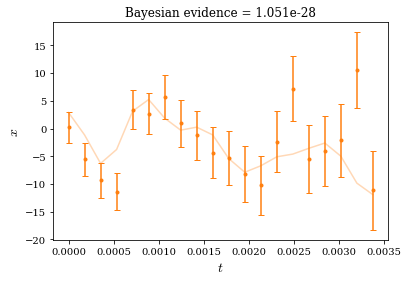

In [3]:
theta_true = np.random.normal(size=(n_params))
mu_true = mu_data(x, theta_true)
y = np.random.normal(mu_true, ystd)

evidence_y = evidence_analytic(y, matrix_operation(x, n_params), np.zeros(n_params),
                                      np.identity(n_params), np.identity(len(ystd)) * ystd**2)

plt.plot(x*0.5*np.pi*0.5/365., mu_true, c='C1' , alpha=0.3)
plt.errorbar(x*0.5*np.pi*0.5/365., y, yerr=ystd, fmt='.C1', capsize=3.45)
plt.xlabel(r'$t$', fontsize=14),plt.ylabel(r'$x$', fontsize=14)
plt.title('Bayesian evidence = ' + str("%.3e" % evidence_y))

## Bayes factor: $\theta_0=0?$

In [4]:
K_true = bayes_factor_theta_0(y, x, n_params,ystd)
print('log K = ', str(np.log(K_true))[:5], '(logK > 0 implies \\theta_0=0 is disfavoured)')

log K =  0.135 (logK > 0 implies \theta_0=0 is disfavoured)


Text(0.5, 1.0, 'Example data sample $x$ from $p(x,m)$\n$\\log_{10} K = $0.05')

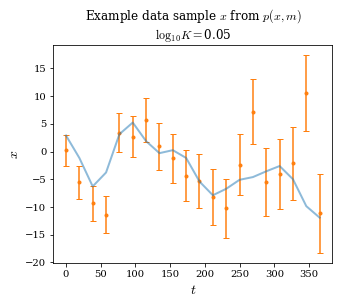

In [5]:
plt.figure(figsize=(5,4))
plt.errorbar(x/x.max()*365, y, yerr=ystd, fmt='.C1', capsize=3.45)
plt.plot(x/x.max()*365, mu_true, lw=2, c='C0' , alpha=.5, zorder=2.5)
plt.xlabel(r'$t$', fontsize=14),plt.ylabel(r'$x$', fontsize=14)
plt.title(r'Example data sample $x$ from $p(x,m)$'+ '\n' +r'$\log_{10} K = $' + str(np.log10(K_true))[:4])

# Generate training data (drawn from each model: $M_1$ & $M_0$)

In [6]:
model_0_fraction = 0.5
validation_fraction = 0.1

In [7]:
n_sample = int((1e6 * ((N/100.)**2.1)*10./9.))
training_theta = np.zeros(shape=(0,n_params))
training_model = np.zeros(shape=(0,2))
training_data = np.zeros((0,N), dtype = 'float')

In [8]:
training_model = np.random.choice(np.arange(2, dtype=np.float32),
                                  p=[model_0_fraction,
                                     1. - model_0_fraction],
                                  size=n_sample)

training_theta = np.random.normal(size=(n_sample,n_params))
training_theta[:,0] = training_model * training_theta[:,0]

training_data = np.random.normal(mu_data(x, training_theta).T,ystd)


print('Current prior model ratio (model 1/model 0): ',
      np.sum(training_model)/np.sum(1 - training_model),
      flush=True)

n_validation = int(validation_fraction*training_model.shape[0])

scale_rescale = 40.*np.std(training_data,axis=0)

Current prior model ratio (model 1/model 0):  1.0089731


# Evidence Net

In [9]:
n_test_calc = np.min([n_validation,20000])

validation_data = training_data[-n_test_calc:]
validation_data_rescaled = 0.5+(validation_data)/scale_rescale
validation_model = np.atleast_2d([training_model[-n_test_calc:], 1. -training_model[-n_test_calc:]]).T

analytic_bayes_factor = bayes_factor_theta_0(validation_data, x, n_params,ystd) 
    

In [10]:
model_instances = []
model_instances_model = []
histories = []

epochs = 20
n_models = 4

# CPU or GPU
with tf.device('/device:CPU:0'):
    
    for model_count in range(n_models):
        
        model_instances.append(EvidenceNetworkSimple(N, weight_init='he_normal',
                                            layer_width=16, added_layers=1,
                                            learning_rate=1e-4, decay_rate=0.95,
                                            batch_norm_flag=1, alpha=2))


        model_instances_model.append(model_instances[-1].model())
                               
        validation_prediction = (model_instances_model[-1].predict(validation_data_rescaled))
        print('Initialization: mean =', validation_prediction.mean(), 'std= ', validation_prediction.std())
                               
                               
        histories.append(model_instances_model[-1].fit(0.5+np.vstack([training_data[:-n_validation],-training_data[:-n_validation]])/scale_rescale,
                             np.atleast_2d(np.hstack([training_model[:-n_validation],training_model[:-n_validation]])).T,
                             epochs=epochs, batch_size=100,
                             shuffle=True,
                             validation_data=(0.5+np.vstack([training_data[-n_validation:],-training_data[-n_validation:]])/scale_rescale,
                                               np.atleast_2d(np.hstack([training_model[-n_validation:],training_model[-n_validation:]])).T),
                             verbose=1))
        
        gc.collect()

Hyper-parameters:Metal device set to: Apple M1
 20 he_normal 16 1 0.0001 0.95 1 0
119/119 [==============================] - 0s 326us/step
Initialization: mean = -0.07886302 std=  0.006571128
Epoch 1/20


2023-08-07 17:54:06.252065: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


682/682 [==============================] - 1s 891us/step - loss: 1.0027 - lr: 9.9650e-05 - val_loss: 1.0005 - val_lr: 9.9303e-05
Epoch 2/20
682/682 [==============================] - 0s 721us/step - loss: 0.9926 - lr: 9.8956e-05 - val_loss: 0.9966 - val_lr: 9.8610e-05
Epoch 3/20
682/682 [==============================] - 1s 737us/step - loss: 0.9812 - lr: 9.8266e-05 - val_loss: 0.9860 - val_lr: 9.7923e-05
Epoch 4/20
682/682 [==============================] - 0s 722us/step - loss: 0.9713 - lr: 9.7581e-05 - val_loss: 0.9717 - val_lr: 9.7240e-05
Epoch 5/20
682/682 [==============================] - 0s 726us/step - loss: 0.9678 - lr: 9.6900e-05 - val_loss: 0.9683 - val_lr: 9.6562e-05
Epoch 6/20
682/682 [==============================] - 0s 725us/step - loss: 0.9647 - lr: 9.6225e-05 - val_loss: 0.9682 - val_lr: 9.5889e-05
Epoch 7/20
682/682 [==============================] - 0s 732us/step - loss: 0.9635 - lr: 9.5554e-05 - val_loss: 0.9652 - val_lr: 9.5220e-05
Epoch 8/20
682/682 [===========

682/682 [==============================] - 0s 727us/step - loss: 0.9616 - lr: 8.9097e-05 - val_loss: 0.9623 - val_lr: 8.8786e-05
Epoch 18/20
682/682 [==============================] - 1s 736us/step - loss: 0.9618 - lr: 8.8476e-05 - val_loss: 0.9618 - val_lr: 8.8167e-05
Epoch 19/20
682/682 [==============================] - 0s 733us/step - loss: 0.9610 - lr: 8.7859e-05 - val_loss: 0.9617 - val_lr: 8.7553e-05
Epoch 20/20
682/682 [==============================] - 0s 727us/step - loss: 0.9611 - lr: 8.7246e-05 - val_loss: 0.9618 - val_lr: 8.6942e-05
Hyper-parameters: 20 he_normal 16 1 0.0001 0.95 1 0
119/119 [==============================] - 0s 319us/step
Initialization: mean = -0.12812425 std=  0.009015477
Epoch 1/20
682/682 [==============================] - 1s 875us/step - loss: 1.0028 - lr: 9.9650e-05 - val_loss: 1.0021 - val_lr: 9.9303e-05
Epoch 2/20
682/682 [==============================] - 0s 730us/step - loss: 0.9989 - lr: 9.8956e-05 - val_loss: 1.0013 - val_lr: 9.8610e-05
Epoch 

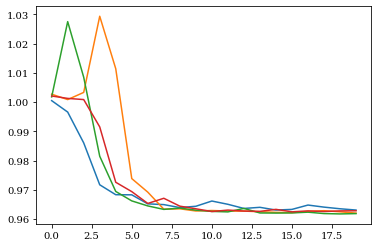

In [11]:
for i in range(n_models):
#     _ = plt.plot(histories[i].history['loss'][:])
    _ = plt.plot(histories[i].history['val_loss'][:])

In [12]:
validation_prediction_array = np.array([(model_instances_model[i].predict(1.-validation_data_rescaled)) \
                          for i in range(n_models)])
validation_prediction = validation_prediction_array.mean(axis=0).flatten()

119/119 [==============================] - 1s 4ms/step


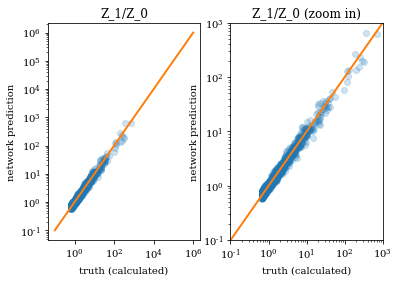

In [13]:
_ = plt.subplot(121), plt.title('Z_1/Z_0')
_ = plt.scatter(analytic_bayes_factor,
                np.exp(validation_prediction), alpha=0.2)
_ = plt.plot([1e-1,1e6],[1e-1,1e6], lw=2, c='C1')
_ = plt.xlabel('truth (calculated)'), plt.ylabel('network prediction')
_ = plt.loglog()
_ = plt.subplot(122), plt.title('Z_1/Z_0 (zoom in)')
_ = plt.ylim(1e-1,1e3),plt.xlim(1e-1,1e3)
_ = plt.scatter(analytic_bayes_factor,
                np.exp(validation_prediction), alpha=0.2)
_ = plt.plot([1e-2,1e6],[1e-2,1e6], lw=2, c='C1')
_ = plt.xlabel('truth (calculated)'), plt.ylabel('network prediction')
_ = plt.loglog()

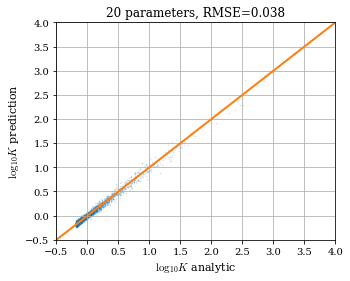

In [14]:
plt.figure(figsize=(5,4))
_ = plt.ylim(-0.5,4),plt.xlim(-0.5,4)
log_K_analytic = np.log10(analytic_bayes_factor).flatten()
log_K_net = np.log10(np.exp(validation_prediction)).flatten()
_ = plt.title(str(N) + ' parameters, RMSE=' + str(np.sqrt(np.mean((log_K_analytic-log_K_net)**2.)))[:5])
_ = plt.scatter(log_K_analytic,log_K_net, alpha=0.2, marker='.',s=1)
_ = plt.plot([-5,1e6],[-5,1e6], lw=2, c='C1')

_ = plt.xlabel(r'$\log_{10}K$ analytic',fontsize=11)
plt.ylabel(r'$\log_{10}K$ prediction',fontsize=11)
plt.grid(True)

# Coverage tests

In [15]:
analytic_posterior_model_prob = analytic_bayes_factor/(1+analytic_bayes_factor)
net_posterior_model_prob = np.exp(validation_prediction)/(1+np.exp(validation_prediction))

In [16]:
prob_analytic, label_fraction_analytic, label_counts_analytic = coverage_test(analytic_posterior_model_prob,
                                                                                   validation_model[:,0])

prob_net, label_fraction_net, label_counts_net = coverage_test(np.array(net_posterior_model_prob.flatten()),
                                                                     validation_model[:,0])

binomial_std_analytic = np.sqrt((prob_analytic*(1.-prob_analytic))/label_counts_analytic)
binomial_std_net = np.sqrt((prob_net*(1.-prob_net))/label_counts_net)

/Users/jeffrey/Documents/EvidenceNetworksDemo/network_architecture.py:27: RuntimeWarning: Mean of empty slice.
  label_fraction.append(float(labels_in_prob_bin.mean()))
/Users/jeffrey/miniforge3/envs/tfenv/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


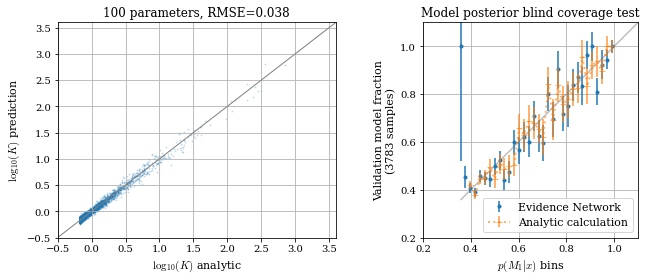

In [17]:
plt.figure(figsize=(9.5,4))

_ = plt.subplot(1,2,1)
_ = plt.ylim(-0.5,3.6),plt.xlim(-0.5,3.6)
_ = plt.plot([-5,1e6],[-5,1e6], lw=1, c='gray')
log_K_analytic = np.log10(analytic_bayes_factor).flatten()
log_K_net = np.log10(np.exp(validation_prediction)).flatten()
_ = plt.title('100 parameters, RMSE=' + str(np.sqrt(np.mean((log_K_analytic-log_K_net)**2.)))[:5])
_ = plt.scatter(log_K_analytic,log_K_net, alpha=0.2, marker='.',s=3)

_ = plt.xlabel(r'$\log_{10}(K)$ analytic',fontsize=11)
plt.ylabel(r'$\log_{10}(K)$ prediction',fontsize=11)
plt.grid(True), plt.tight_layout()

_ = plt.subplot(1,2,2)
probability_array  = np.linspace(0.2,1,20)
plt.plot(probability_array[3:]*1.1,probability_array[3:]*1.1, c='gray', alpha=0.5)
plt.errorbar(prob_net, label_fraction_net, binomial_std_net, ls='',marker ='.',label='Evidence Network')
plt.errorbar(prob_analytic, label_fraction_analytic, binomial_std_analytic,marker='_',
             label='Analytic calculation', ls=':', lw=2, alpha=0.6,zorder=2.5)
plt.title('Model posterior blind coverage test')
plt.xlabel(r'$p(M_1 | x)$ bins', fontsize=11)
plt.ylabel(str('Validation model fraction\n('+str(n_test_calc) + ' samples)'), fontsize=11)
plt.axis('square')
plt.grid(True), plt.legend( fontsize=11)
plt.ylim(0.2,1.1)
plt.xlim(0.2,1.1)
plt.tight_layout()
plt.subplots_adjust(wspace=0.2)

In [18]:
rescaled_residuals_net = (prob_net -  label_fraction_net) / binomial_std_net
rescaled_residuals_analytic = (prob_analytic -  label_fraction_analytic) / binomial_std_analytic

(None, <matplotlib.legend.Legend at 0x29f09dc30>)

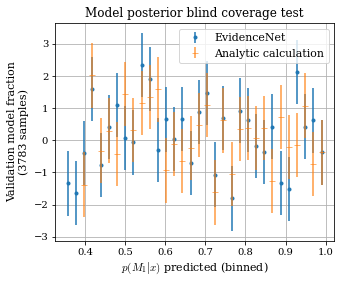

In [19]:
plt.figure(figsize=(5,4))
probability_array  = np.linspace(0.2,1,20)
plt.errorbar(prob_net, rescaled_residuals_net, 1.,
             ls='',marker ='.',label='EvidenceNet')
plt.errorbar(prob_analytic, rescaled_residuals_analytic, 1,
             marker='_',label='Analytic calculation', ls='', lw=2, alpha=0.6,zorder=2.5)
plt.title('Model posterior blind coverage test')
plt.xlabel(r'$p(M_1 | x)$ predicted (binned)', fontsize=11)
plt.ylabel(str('Validation model fraction\n('+str(n_test_calc) + ' samples)'), fontsize=11)
plt.grid(True), plt.legend( fontsize=11)

In [20]:
print('Mean, std, rmse rescaled residuals')
print('Evidence Network:', rescaled_residuals_net.mean(),
      rescaled_residuals_net.std(),
      np.sqrt((rescaled_residuals_net**2.).mean()))
print('Analytic:', rescaled_residuals_analytic.mean(),
      rescaled_residuals_analytic.std(),
      np.sqrt((rescaled_residuals_analytic**2.).mean()))

Mean, std, rmse rescaled residuals
Evidence Network: 0.156416288098711 1.082809303781291 1.0940484648944504
Analytic: 0.12926367361709545 0.9140435806825358 0.923138540363221
